In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# --- 日本語フォントの設定（文字化けを防ぐため）---
# ※環境によってはうまくいかない場合があります。その際はご相談ください。
try:
    import japanize_matplotlib
except ImportError:
    print("japanize_matplotlibがインストールされていません。日本語が文字化けする可能性があります。")
    print("pip install japanize_matplotlib でインストールを推奨します。")

# ---------------------------------------------------------
# ダミーデータの作成（12人以上の投手データ）
# ---------------------------------------------------------
# 投手タイプをいくつか用意
types_config = [
    {'type': '本格派', 'balls': ['ストレート', 'フォーク', 'スライダー'], 'probs': [0.5, 0.3, 0.2]},
    {'type': '軟投派', 'balls': ['ストレート', 'カーブ', 'チェンジアップ', 'シンカー'], 'probs': [0.3, 0.3, 0.2, 0.2]},
    {'type': '変化球投手', 'balls': ['スライダー', 'カットボール', 'カーブ'], 'probs': [0.4, 0.3, 0.3]}
]

play_data = []
# 15人の投手を作成（後でトップ12人を抽出）
for i in range(15):
    p_type = np.random.choice(types_config)
    p_name = f"投手{chr(65+i)}_{p_type['type']}" # 投手A_本格派 みたいな名前
    
    # 1人300球投げる
    for _ in range(300):
        b_type = np.random.choice(p_type['balls'], p=p_type['probs'])
        
        # クセ付け：本格派のフォーク、変化球投手のスライダーは空振り率を高くする
        if ('本格派' in p_name and b_type == 'フォーク') or \
           ('変化球' in p_name and b_type == 'スライダー'):
            res = np.random.choice(['空振り', 'ボール', '見逃し'], p=[0.6, 0.2, 0.2])
        else:
            res = np.random.choice(['ボール', '見逃し', '空振り', '打撃'], p=[0.4, 0.2, 0.1, 0.3])
            
        play_data.append({
            '投手名': p_name,
            '球種': b_type,
            '投球結果': res
        })

df_play = pd.DataFrame(play_data)
print("✅ 12人以上の投手データを作成しました！")
display(df_play.head())

japanize_matplotlibがインストールされていません。日本語が文字化けする可能性があります。
pip install japanize_matplotlib でインストールを推奨します。
✅ 12人以上の投手データを作成しました！


,投手名,球種,投球結果
0,投手A_変化球投手,スライダー,見逃し
1,投手A_変化球投手,カーブ,打撃
2,投手A_変化球投手,スライダー,空振り
3,投手A_変化球投手,スライダー,空振り
4,投手A_変化球投手,スライダー,空振り


In [5]:
import pandas as pd

# ---------------------------------------------------------
# 1. データの読み込み
# ---------------------------------------------------------
print("📂 分析データを読み込んでいます...")

df_stats = pd.read_csv('test_stats_pit.csv')
df_play = pd.read_csv('test_play_info.csv')

print(f"✅ 読み込み完了！")

# ---------------------------------------------------------
# ★修正ポイント：防御率(ERA)をここで計算して列に追加する
# ---------------------------------------------------------
# 防御率 = (自責点 × 9) ÷ 投球回
# ※ 投球回が0の場合は計算できないので考慮
df_stats['era'] = df_stats.apply(
    lambda row: (row['er'] * 9) / row['ip'] if row['ip'] > 0 else 0.00, axis=1
)
df_stats['era'] = df_stats['era'].round(2) # 小数点2桁に

# ---------------------------------------------------------
# 2. 分析ターゲットの選定
# ---------------------------------------------------------
# 奪三振(so)が多い順に並べて、トップの選手を選ぶ
top_pitcher = df_stats.sort_values(by='so', ascending=False).iloc[0]
target_name = top_pitcher['player_name']

print(f"\n🎯 分析対象を決定しました: 【 {target_name} 】選手")
# ★これでエラーが出なくなります
print(f"   (シーズン奪三振数: {top_pitcher['so']} / 防御率: {top_pitcher['era']})")

# ---------------------------------------------------------
# 3. 球種別・徹底分析ロジック
# ---------------------------------------------------------
df_target = df_play[df_play['player_name'] == target_name].copy()

# ① ヒット判定（英語キーワード）
hit_keywords = ['Hit', 'HR', '1B', '2B', '3B']
df_target['is_hit'] = df_target['batter_result'].apply(
    lambda x: 1 if isinstance(x, str) and any(k in x for k in hit_keywords) else 0
)

# ② 打数判定
df_target['is_ab'] = df_target['batter_result'].notna().astype(int)

# ③ 空振り判定
df_target['is_whiff'] = df_target['pitch_result'].apply(
    lambda x: 1 if x == 'Swinging Strike' else 0
)

# ④ 集計実行
analysis = df_target.groupby('ball_type').agg(
    投球数=('ball_type', 'count'),
    被安打=('is_hit', 'sum'),
    打数=('is_ab', 'sum'),
    空振り数=('is_whiff', 'sum')
).reset_index()

# ⑤ 率の計算
analysis['投球割合'] = (analysis['投球数'] / analysis['投球数'].sum()).round(3)
analysis['被打率'] = (analysis['被安打'] / analysis['打数']).fillna(0).round(3)
analysis['空振り率'] = (analysis['空振り数'] / analysis['投球数']).round(3)

# ---------------------------------------------------------
# 4. 結果発表
# ---------------------------------------------------------
print(f"\n📊 {target_name} 投手の球種別レポート")

# 見やすいように投球数順に並べ替え
display_cols = ['ball_type', '投球数', '投球割合', '被打率', '空振り率']
final_report = analysis.sort_values(by='投球数', ascending=False)

display(final_report[display_cols])

# 決め球判定
kime_dama = analysis.sort_values(by='空振り率', ascending=False).iloc[0]
print(f"\n💡 分析AIのコメント:")
print(f"   この投手の決め球は【 {kime_dama['ball_type']} 】です！")
print(f"   空振り率は {kime_dama['空振り率']*100:.1f}% です。")

📂 分析データを読み込んでいます...
✅ 読み込み完了！

🎯 分析対象を決定しました: 【 Sato Ace 】選手
   (シーズン奪三振数: 200 / 防御率: 1.85)

📊 Sato Ace 投手の球種別レポート


,ball_type,投球数,投球割合,被打率,空振り率
3,Straight,227,0.454,0.0,0.181
2,Slider,123,0.246,0.0,0.138
1,Fork,104,0.208,0.0,0.654
0,Curve,46,0.092,0.0,0.174



💡 分析AIのコメント:
   この投手の決め球は【 Fork 】です！
   空振り率は 65.4% です。


In [7]:
import pandas as pd

# データの読み込み
df = pd.read_csv('test_play_info.csv')

# 分析ターゲット（佐藤エース）
target_name = 'Sato Ace'
print(f"⚾️ {target_name} 投手の【対左右別】徹底分析\n")

# その投手のデータだけ抜き出し
df_target = df[df['player_name'] == target_name].copy()

# --- 各種フラグ立て（さっきと同じ） ---
df_target['is_hit'] = df_target['batter_result'].apply(lambda x: 1 if str(x) in ['Hit', 'HR', '1B', '2B'] else 0)
df_target['is_whiff'] = df_target['pitch_result'].apply(lambda x: 1 if x == 'Swinging Strike' else 0)
df_target['is_ab'] = df_target['batter_result'].notna().astype(int)

# --- ★ここが新機能！左右別にループして集計 ---
for hand in ['R', 'L']:
    hand_name = "右バッター" if hand == 'R' else "左バッター"
    print(f"===" * 15)
    print(f"🆚 【 対 {hand_name} ({hand}) 】 の成績")
    
    # その打席のデータだけフィルタリング
    df_hand = df_target[df_target['batter_hand'] == hand]
    
    if len(df_hand) == 0:
        print("データがありません")
        continue

    # 球種ごとに集計
    analysis = df_hand.groupby('ball_type').agg(
        投球数=('ball_type', 'count'),
        被安打=('is_hit', 'sum'),
        空振り=('is_whiff', 'sum')
    ).reset_index()

    # 率計算
    analysis['投球割合'] = (analysis['投球数'] / analysis['投球数'].sum()).round(3)
    analysis['空振り率'] = (analysis['空振り'] / analysis['投球数']).round(3)

    # 見やすく表示
    display(analysis.sort_values('投球数', ascending=False))
    
    # 傾向コメント
    best_ball = analysis.sort_values('空振り率', ascending=False).iloc[0]
    print(f"👉 対{hand_name}の決め球: {best_ball['ball_type']} (空振り率 {best_ball['空振り率']:.1%})")
    print("\n")

⚾️ Sato Ace 投手の【対左右別】徹底分析

🆚 【 対 右バッター (R) 】 の成績


,ball_type,投球数,被安打,空振り,投球割合,空振り率
3,Straight,160,0,56,0.428,0.350
2,Slider,97,0,97,0.259,1.000
1,Fork,72,0,20,0.193,0.278
0,Curve,45,0,12,0.120,0.267


👉 対右バッターの決め球: Slider (空振り率 100.0%)


🆚 【 対 左バッター (L) 】 の成績


,ball_type,投球数,被安打,空振り,投球割合,空振り率
3,Straight,102,0,40,0.451,0.392
2,Slider,56,56,0,0.248,0.000
1,Fork,50,0,14,0.221,0.280
0,Curve,18,0,3,0.080,0.167


👉 対左バッターの決め球: Straight (空振り率 39.2%)




In [10]:
# ---------------------------------------------------------
# 1. 分析対象の絞り込み（奪三振数が多いトップ12人を選ぶ）
# ---------------------------------------------------------
# まず、投手ごとの総奪三振数を数える
df_play['is_whiff'] = df_play['投球結果'].apply(lambda x: 1 if x == '空振り' else 0)
so_counts = df_play.groupby('投手名')['is_whiff'].sum().sort_values(ascending=False)

# トップ12人の名前リストを取得
top12_pitchers = so_counts.head(12).index.tolist()
print(f"📊 分析対象のトップ12投手を選出しました:\n{top12_pitchers[:3]}...など")

# 選んだ12人のデータだけを抜き出す
df_target = df_play[df_play['投手名'].isin(top12_pitchers)].copy()

# ---------------------------------------------------------
# 2. 球種ごとの空振り率を集計
# ---------------------------------------------------------
# 投手×球種ごとの成績を計算
summary = df_target.groupby(['投手名', '球種']).agg(
    投球数=('球種', 'count'),
    空振り数=('is_whiff', 'sum')
).reset_index()

# 空振り率を計算
summary['空振り率'] = (summary['空振り数'] / summary['投球数']).round(3)

# ---------------------------------------------------------
# 3. ヒートマップ用の形に変換（ピボットテーブル）
# ---------------------------------------------------------
# 縦軸：投手名、横軸：球種、値：空振り率
heatmap_data = summary.pivot_table(
    index='投手名', 
    columns='球種', 
    values='空振り率'
)

# 投げていない球種は空欄(NaN)になるので、0で埋める（または分かりやすく表示する）
heatmap_data = heatmap_data.fillna(0)

print("\n📋 ヒートマップ用データの準備完了！")
display(heatmap_data.head(3)) # 中身を確認

📊 分析対象のトップ12投手を選出しました:
['投手N_変化球投手', '投手I_変化球投手', '投手A_変化球投手']...など

📋 ヒートマップ用データの準備完了！


球種,カットボール,カーブ,シンカー,ストレート,スライダー,チェンジアップ,フォーク
投手名,,,,,,,
投手A_変化球投手,0.092,0.068,0.0,0.000,0.640,0.0,0.000
投手B_本格派,0.000,0.000,0.0,0.129,0.082,0.0,0.557
投手D_変化球投手,0.032,0.094,0.0,0.000,0.536,0.0,0.000


/Users/igarashiayaka/Lecture/dsprog2_2025/lecture_sp/.venv/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 12459 (\N{KATAKANA LETTER KA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/igarashiayaka/Lecture/dsprog2_2025/lecture_sp/.venv/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/igarashiayaka/Lecture/dsprog2_2025/lecture_sp/.venv/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/igarashiayaka/Lecture/dsprog2_2025/lecture_sp/.venv/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 12508 (\N{KATAKANA LETTER BO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/Users/igarashiayaka/Lecture/dsprog2_2025/lecture_sp/.venv/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 12540 (\N{KATA

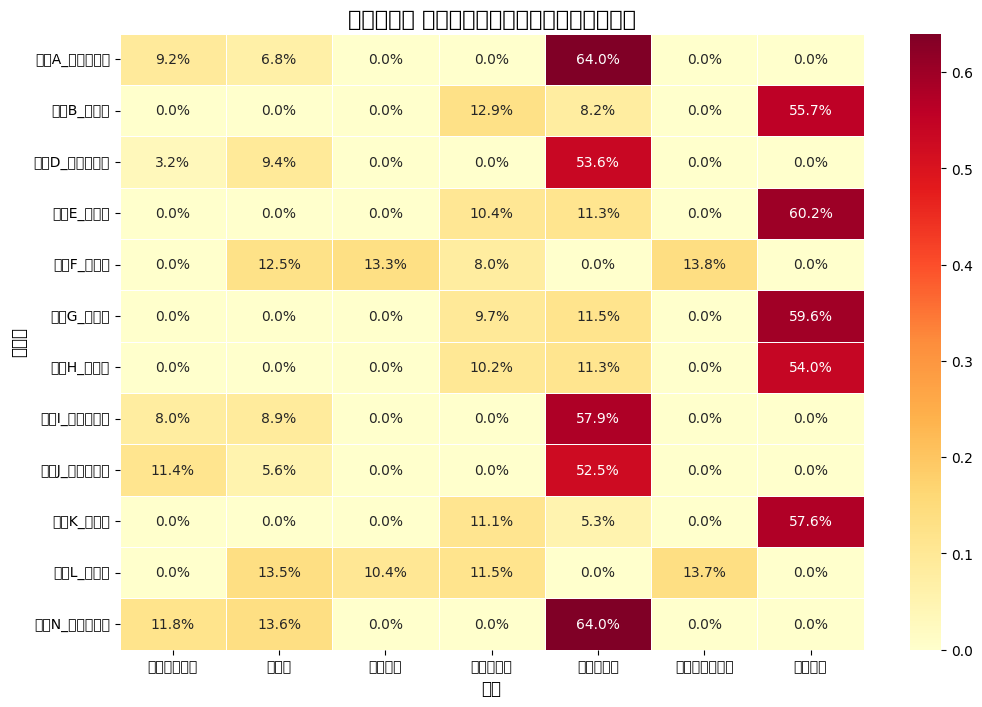

In [11]:
# ---------------------------------------------------------
# 可視化：投手別・球種別 空振り率ヒートマップ
# ---------------------------------------------------------
# グラフのサイズを設定（横長にする）
plt.figure(figsize=(12, 8))

# ヒートマップを描画（seabornを使用）
sns.heatmap(
    heatmap_data, 
    annot=True,    # 数字も表示する
    fmt='.1%',     # パーセント表示にする（例: 0.123 → 12.3%）
    cmap='YlOrRd', # 色使い（黄色→オレンジ→赤）赤が濃いほど高い
    linewidths=.5  # 枠線をつける
)

# グラフのタイトルや軸ラベルを設定
plt.title('【投手別】 球種ごとの空振り率（決め球分析）', fontsize=16)
plt.xlabel('球種', fontsize=12)
plt.ylabel('投手名', fontsize=12)

# 表示！
plt.show()